### Optimizing the CA criteria using keras

In [1]:
import numpy as np
import uproot
import math

In [3]:
f = uproot.open( "mltree.root" )
mltree = f["Stg"]

<TTree b'Stg' at 0x000117ea84a8>

In [5]:
import matplotlib.pyplot as plt
fs = ( 16, 9 ) # lets make all our figures 16 by 9

In [6]:
xyztv = mltree.arrays( [ "x", "y", "z", "tid", "vid" ]  )
mct = mltree.arrays( ["pt", "eta", "phi"] )

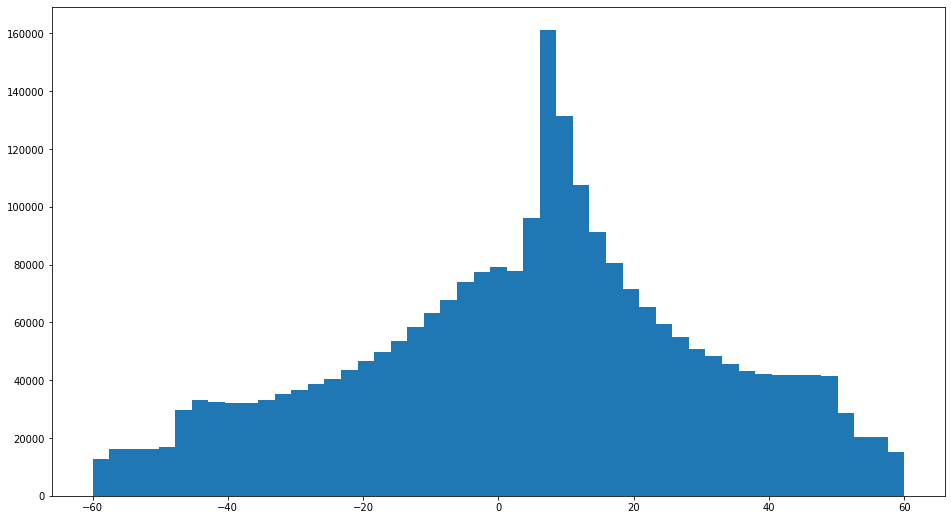

In [9]:
plt.figure(figsize=fs)
plt.hist( xyztv[b"y"].flatten(), bins=np.linspace(-60, 60, 50) )
plt.show()

In [20]:
class HitPoint:
    def __init__( self, _x, _y, _z, _v, _t ):
        self.x = _x
        self.y = _y
        self.z = _z
        self.v = _v
        self.t = _t
    def __repr__( self ):
        return 'HitPoint[v=%d, (%0.3f, %0.3f, %0.3f), tid=%d]' % ( self.v, self.x, self.y, self.z, self.t )
class TwoHit:
    def __init__( self, _a, _b):
        self.a = _a
        self.b = _b

    
class CriteriaResult:
    def __init__(self):
        self.real = False
        self.res = -99
        self.pt = -99
        self.eta = -99
        self.phi = -99
    
        
def generate_vol_map( x, y, z, v, t, phi0, phi1 ):
    vol_map = [ [], [], [], [] ] # maps to 4 volumes
    for _x, _y, _z, _v, _t in zip(  x, y, z, v, t ):
        phi = math.atan2( _y, _x )
        if phi < phi1 and phi >= phi0 :
            vol_map[_v].append( HitPoint( _x, _y, _z, _v, _t ) )
    return vol_map
    #vol_map[]
    #print( len(x) )

def gen_pairs( vm ) :
    hp = []
    for i in np.arange( 0, 3 ):
        for a in vm[i] :
            for b in vm[i+1]:
                hp.append( (a,b) )
    return hp

def process_pairs( hp, pts, crit ):
    crs = []
    
    for points in hp:
        a = points[0]
        b = points[1]
        cr = CriteriaResult()
        cr.res = crit(a, b)
        cr.real = (a.t == b.t)
        if cr.real :
            cr.pt = pts[a.t - 1]
        crs.append( cr )
        
    return crs


def crit_rz( a, b ):
    dx = a.x-b.x
    dy = a.y-b.y
    dz = a.z-b.z
    return (dx**2+dy**2+dz**2)/dz**2;

M_PI = 3.1415926
def crit_dphi( a, b ):
    phia = math.atan2( a.y, a.x )
    phib = math.atan2(b.y, b.x)
    deltaPhi = phia-phib
    if deltaPhi > M_PI :
        deltaPhi = deltaPhi - 2*M_PI
    if deltaPhi < -M_PI:
        deltaPhi = deltaPhi + 2*M_PI
    if ( b.y*b.y + b.x*b.x < 0.0001 ) or ( a.y*a.y + a.x*a.x < 0.0001 ):
        deltaPhi = 0
    deltaPhi = 180. * math.fabs( deltaPhi ) / M_PI
    return deltaPhi

def crit_deltaRho( a, b ):
    rhoA =  math.sqrt( a.x*a.x + a.y*a.y );
    rhoB =  math.sqrt( b.x*b.x + b.y*b.y );

    deltaRho = rhoA - rhoB;
    return deltaRho

def pair_stats( pairs ):
    nr = 0
    nf = 0
    for p in pairs:
        if p[0].t == p[1].t:
            nr = nr + 1
        else :
            nf = nf + 1
#     print( "There are %d real and %d fake pairs, with %f %% real" % ( nr, nf, (nr / len(pairs)) ) ) 
    return (nr, nf, (nr / len(pairs)) )

In [23]:
iEvent = 0
vm = generate_vol_map( xyztv[b"x"][iEvent], xyztv[b"y"][iEvent], xyztv[b"z"][iEvent], xyztv[b"vid"][iEvent], xyztv[b"tid"][iEvent], 0, math.pi / 2.0 )
pairs = gen_pairs(vm)

pairs

[(HitPoint[v=0, (7.543, 20.994, 280.905), tid=302],
  HitPoint[v=1, (8.503, 24.978, 303.705), tid=302]),
 (HitPoint[v=0, (7.543, 20.994, 280.905), tid=302],
  HitPoint[v=1, (16.451, 21.481, 303.705), tid=328]),
 (HitPoint[v=0, (14.246, 18.194, 280.905), tid=328],
  HitPoint[v=1, (8.503, 24.978, 303.705), tid=302]),
 (HitPoint[v=0, (14.246, 18.194, 280.905), tid=328],
  HitPoint[v=1, (16.451, 21.481, 303.705), tid=328]),
 (HitPoint[v=1, (8.503, 24.978, 303.705), tid=302],
  HitPoint[v=2, (9.475, 29.001, 326.605), tid=302]),
 (HitPoint[v=1, (8.503, 24.978, 303.705), tid=302],
  HitPoint[v=2, (18.730, 24.746, 326.605), tid=328]),
 (HitPoint[v=1, (16.451, 21.481, 303.705), tid=328],
  HitPoint[v=2, (9.475, 29.001, 326.605), tid=302]),
 (HitPoint[v=1, (16.451, 21.481, 303.705), tid=328],
  HitPoint[v=2, (18.730, 24.746, 326.605), tid=328]),
 (HitPoint[v=2, (9.475, 29.001, 326.605), tid=302],
  HitPoint[v=3, (10.435, 32.974, 349.405), tid=302]),
 (HitPoint[v=2, (9.475, 29.001, 326.605), tid=

In [31]:
all_pairs = []
all_mapped_pts = []
all_RZ = []
all_DP = []
all_DR = []

for iEvent in np.arange( len(xyztv[b"x"]) ) :
    vm = generate_vol_map( xyztv[b"x"][iEvent], xyztv[b"y"][iEvent], xyztv[b"z"][iEvent], xyztv[b"vid"][iEvent], xyztv[b"tid"][iEvent], 0, math.pi/4 )
    pts = mct[ b"pt" ][iEvent]
    pairs = gen_pairs( vm )
    all_pairs.extend( pairs )
    
    mapped_pts = [ pts[ p[0].t ] if p[0].t == p[1].t else 0.0 for p in pairs  ]
    all_mapped_pts.extend( mapped_pts )
    
    if iEvent % 5000 == 0:
        print( "Event %d" %(iEvent))
#     inr, inf, ipur = pair_stats( pairs )

    

Event 0
Event 5000
Event 10000
Event 15000
Event 20000
Event 25000
Event 30000
Event 35000
Event 40000
Event 45000


In [36]:
len(all_pairs)

857586

In [35]:
all_RZ = [ crit_rz( p[0], p[1] ) for p in all_pairs ]

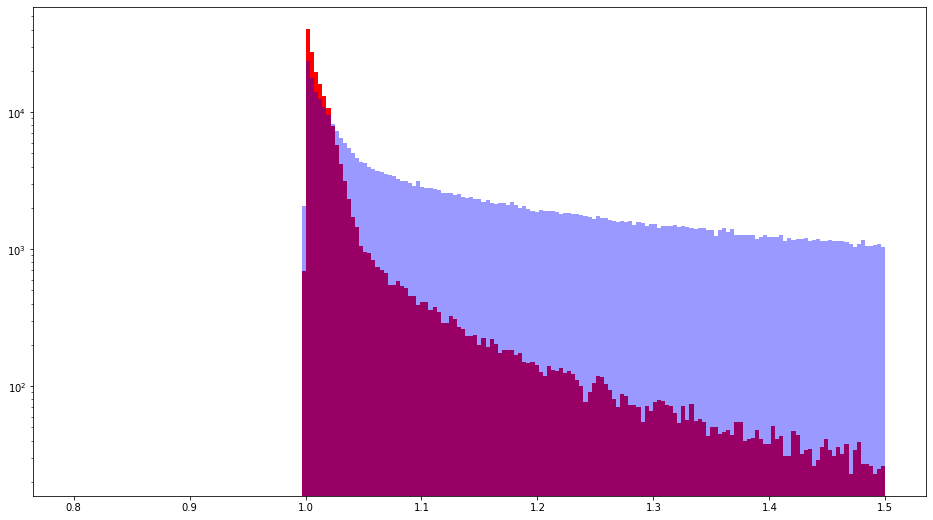

In [51]:
RZ_real = [ rz for i, rz in enumerate(all_RZ) if all_pairs[i][0].t == all_pairs[i][1].t  ]
RZ_fake = [ rz for i, rz in enumerate(all_RZ) if all_pairs[i][0].t != all_pairs[i][1].t  ]

plt.figure(figsize=fs)
plt.hist( RZ_real, bins=np.linspace(0.8, 1.5, 200), fc='red' )
plt.hist( RZ_fake, bins=np.linspace(0.8, 1.5, 200), fc='blue', alpha=0.4 )
plt.yscale('log')
plt.show()

In [ ]:

all_DP = [ crit_dphi( p[0], p[1] ) for p in all_pairs ]
all_DR = [ crit_deltaRho( p[0], p[1] ) for p in all_pairs ]